# 1. Environment Set Up
- Do neccesary imports
- set up where the data is 

In [1]:
import torch, sys, os, numpy as np, pandas as pd
from tqdm import tqdm
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from fastai.vision.all import *
import timm

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

import albumentations as A
from albumentations.pytorch import ToTensorV2

from skimage import io
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold

from matplotlib import pyplot as plt
import seaborn as sns

from fastai.vision.all import *

In [3]:
ROOT_DIR = "/home/jovyan/wire/DataSets/Kaggle Days 2022 Flying Circus Competition"
#ROOT_DIR = "Z:/Users/Iain/Documents/Data Science Competitions/Flying Circus/"

In [2]:
#ROOT_DIR = "Z:/Users/Iain/Documents/Data Science Competitions/Yoga Images/"
ROOT_DIR = "/home/jovyan/wire/DataSets/Kaggle Days Yoga Poses Competition"
train_df = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(ROOT_DIR, "sample_submission.csv"))
train_df['path'] = train_df['image_id'].apply(lambda x: os.path.join("images", "train_images", x))
test_df['path'] = test_df['image_id'].apply(lambda x: os.path.join("images", "test_images", x))

# 2. Specify Additional Useful Functions (Utils)
- ArcFace Loss
- Transformation function to convert imaages to RGB

https://www.kaggle.com/code/slawekbiel/arcface-explained

In [3]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, s=30.0, m=0.50, easy_margin=False, ls_eps=0.0, final_loss = FocalLossFlat()):
        super(ArcMarginProduct, self).__init__()
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.easy_margin = easy_margin
        self.final_loss = final_loss
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, cosine, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        sine = torch.sqrt(1.0 - torch.pow(cosine,2)).to(cosine.dtype) #needed for to_fp16()
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size(), device=CFG.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return self.final_loss(output, label)

In [4]:
def arcface_loss(cosine, targ, m=.4):
    # this prevents nan when a value slightly crosses 1.0 due to numerical error
    cosine = cosine.clip(-1+1e-7, 1-1e-7) 
    # Step 3:
    arcosine = cosine.arccos()
    # Step 4:
    one_hot = torch.zeros(cosine.size(), device='cuda')
    one_hot.scatter_(1, targ.view(-1, 1).long(), 1)
    arcosine += one_hot * m
    # Step 5:
    cosine2 = arcosine.cos()
    # Step 6:
    return FocalLossFlat()(cosine2, targ)

In [5]:
class CosineClassifier(nn.Module):
    def __init__(self, emb_size, output_classes):
        super(CosineClassifier, self).__init__()
        self.W = nn.Parameter(torch.Tensor(emb_size, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        # Step 1:
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        # Step 2:
        return x_norm @ W_norm

In [6]:
def convert_to_color(img: PILImage):
    np_img = np.array(img)
    if np_img.ndim <3:
        np_img = np.repeat(np_img[:, :, np.newaxis], 3, axis=2)
    return PILImage.create(np_img)

# 3. EDA + Data Preprocessing
- *note*: this is unique to competition and the following blocks need to be adjusted

In [7]:
train_df = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"), index_col='id')
test_df = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"), index_col='id')
hobbies_df = pd.read_csv(os.path.join(ROOT_DIR, "hobbies.csv"))

In [8]:
hobbies_df['low_age'] = hobbies_df['age'].apply(lambda x : int(x.split('-')[0]))
hobbies_df['high_age'] = hobbies_df['age'].apply(lambda x : int(x.split('-')[1]))

In [9]:
train_df['hobby'] = train_df.apply(lambda x :  hobbies_df[(hobbies_df['celebrity']==x['celebrity'])  & (x['age']>=hobbies_df['low_age']) & (x['age']<=hobbies_df['high_age'])]['hobbies'].item(), axis=1)

In [10]:
train_df['label'] = train_df['hobby'].astype("category").cat.codes

<AxesSubplot:>

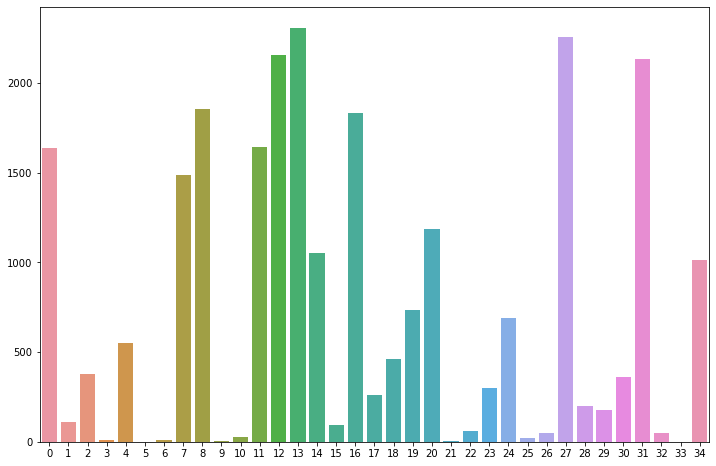

In [11]:
x,y = np.unique(train_df['label'], return_counts=True)
plt.figure(figsize=(12,8))
sns.barplot(x=x, y=y)

In [12]:
np.unique(train_df['hobby'], return_counts=True)

(array(['Acting', 'Archery', 'Calligraphy', 'Coffee', 'Coloring',
        'Cryptography', 'Cycling', 'Dance', 'Drama', 'Drawing',
        'Electronics', 'Embroidery', 'Fashion', 'Gaming', 'Language',
        'Magic', 'Origami', 'Painting', 'Pet', 'Pottery', 'Programming',
        'Puzzles', 'Reading', 'Sculpting', 'Sewing', 'Singing', 'Skating',
        'Sketching', 'Sports', 'Sudoku', 'Vacation', 'Writing', 'Yoga',
        'scrapbook', 'television'], dtype=object),
 array([1636,  108,  380,    8,  551,    1,   12, 1488, 1854,    2,   26,
        1641, 2153, 2307, 1050,   95, 1830,  260,  460,  735, 1185,    3,
          61,  302,  690,   20,   49, 2257,  198,  175,  361, 2135,   51,
           1, 1012]))

In [13]:
# Create copies of instances from labels where there is only one instance

train_df = train_df.append([train_df[train_df['hobby'].isin(['Cryptography', 'scrapbook'])]]*5, ignore_index=True)

/tmp/ipykernel_12770/2807898139.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append([train_df[train_df['hobby'].isin(['Cryptography', 'scrapbook'])]]*5, ignore_index=True)


In [7]:
train_df.head()

,image_id,class_6,path
0,1daf45401342ac321c0aa5668f51d004.jpg,5,images/train_images/1daf45401342ac321c0aa5668f51d004.jpg
1,7e15c14f0b25766d0b7378f1d5328e99.jpg,4,images/train_images/7e15c14f0b25766d0b7378f1d5328e99.jpg
2,1dc97053cf67cb8e51c983abb0021083.jpg,4,images/train_images/1dc97053cf67cb8e51c983abb0021083.jpg
3,0ceaf686d3b9c1db537fed12b568670d.jpg,1,images/train_images/0ceaf686d3b9c1db537fed12b568670d.jpg
4,73adbf71f0adcf89c94339f6a6a92b61.jpg,0,images/train_images/73adbf71f0adcf89c94339f6a6a92b61.jpg


# 2. Set Up Configuration

In [16]:
class CFG:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Data
    batch_size= 38
    img_size = 384
    shuffle=True
    #label_col = "hobby"
    #fn_col = "img_path"
    #data_path = os.path.join(ROOT_DIR, "images", "images")
    label_col='class_6'
    fn_col="path"
    data_path = ROOT_DIR
    
    # Model
    model_name = 'resnext101_64x4d'
    model_path = "/home/jovyan/local_scratch"
    model_dir = "fastai_models"
    pretrained = True
    #num_classes = 35
    num_classes=6
    
    # Training
    epochs = 15
    freeze_epochs=3
    loss_func = BaseLoss(ArcMarginProduct)
    callbacks = [
        EarlyStoppingCallback(monitor="valid_loss", min_delta=0.001, patience=3)
    ]
    metrics = [
        accuracy_multi, F1ScoreMulti
    ]
    num_folds = 4

# 3. Create Data Loaders
- create and check any custom transforms
- add in cross validation

In [9]:
def get_data(df, fold):
    df = df.copy()
    df['is_valid'] = (df['fold'] == fold)
    dls = ImageDataLoaders.from_df(df, num_workers=0,
                                   label_col= CFG.label_col,
                                   fn_col = CFG.fn_col,
                                   path = CFG.data_path,
                                   valid_col='is_valid',
                                   bs = CFG.batch_size,
                                   shuffle = CFG.shuffle,
                                   device = CFG.device,
                                   item_tfms=[convert_to_color, Resize(460)],
                                   batch_tfms=aug_transforms(size=CFG.img_size)
                                  )
    return dls

In [10]:
train_df['fold'] = -1
skf = StratifiedKFold(n_splits=4, shuffle=True)
for i, (_, train_index) in enumerate(skf.split(train_df.index, train_df[CFG.label_col])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

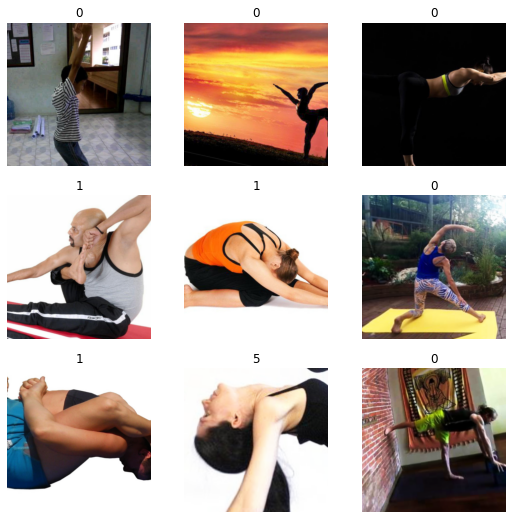

In [11]:
dls = get_data(train_df, 0)
dls.show_batch()

# 4. Train the Model
- Create the model
- Create a FastAI Learner
- Find a good learning rate for model
- Fit a model across different folds of the data


In [12]:
class NN_Model(nn.Module):

    def __init__(self,
                 n_classes,
                 model_name='efficientnet_b0',
                 pretrained=True):
        
        super(NN_Model, self).__init__()

        model = timm.create_model(model_name, pretrained=pretrained)
        final_in_features = list(model.children())[-1].in_features
        self.backbone = nn.Sequential(*list(model.children())[:-1])
        self.classifier = CosineClassifier(final_in_features, n_classes)
        #self.classifier = nn.Linear(final_in_features, n_classes, bias = True)


    def forward(self, x):
        feature = self.backbone(x)
        return self.classifier(feature)


In [13]:
def get_learner(dls):
    model = NN_Model(CFG.num_classes, model_name=CFG.model_name, pretrained=CFG.pretrained).to(CFG.device)
    learn = Learner(dls, model, loss_func=CFG.loss_func, metrics=accuracy, cbs = CFG.callbacks,
                    path=CFG.model_path, model_dir=CFG.model_dir).to_fp16()
    return learn

In [14]:
learn = get_learner(get_data(train_df, 0))

SuggestedLRs(valley=0.03981071710586548)

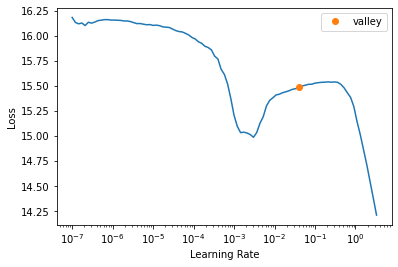

In [15]:
learn.lr_find()

In [17]:
del learn, dls
torch.cuda.empty_cache()

In [19]:
fold = 0 
for i in range(CFG.num_folds):
    learn = get_learner(get_data(train_df, i))
    print( "--------Fold: {}----------".format(fold))
    
    learn.fine_tune(epochs=CFG.epochs, base_lr=1e-4, freeze_epochs=CFG.freeze_epochs, 
                    cbs=[SaveModelCallback(monitor="valid_loss", min_delta=0.001, fname=CFG.model_name+"_"+str(i))])
    
    fold +=1
    del learn
    torch.cuda.empty_cache()

--------Fold: 0----------


epoch,train_loss,valid_loss,accuracy,time
0,15.797666,15.405095,0.449153,01:32
1,13.735320,9.687248,0.700000,01:32
2,9.133975,5.539517,0.818644,01:31


Better model found at epoch 0 with valid_loss value: 15.405095100402832.
Better model found at epoch 1 with valid_loss value: 9.687248229980469.
Better model found at epoch 2 with valid_loss value: 5.539516925811768.


epoch,train_loss,valid_loss,accuracy,time
0,3.168371,4.640472,0.844068,01:31
1,2.472990,4.364242,0.861017,01:31
2,1.962309,4.293277,0.867797,01:32
3,1.541525,3.923949,0.879661,01:30
4,1.227329,3.880861,0.879661,01:31
5,1.067401,3.988115,0.872881,01:30
6,0.891655,3.762488,0.877966,01:31
7,0.618840,4.110748,0.867797,01:31
8,0.458752,3.976511,0.874576,01:30
9,0.394219,3.638090,0.876271,01:31


Better model found at epoch 0 with valid_loss value: 4.640472412109375.
Better model found at epoch 1 with valid_loss value: 4.364241600036621.
Better model found at epoch 2 with valid_loss value: 4.293277263641357.
Better model found at epoch 3 with valid_loss value: 3.9239494800567627.
Better model found at epoch 4 with valid_loss value: 3.8808605670928955.
Better model found at epoch 6 with valid_loss value: 3.7624878883361816.
Better model found at epoch 9 with valid_loss value: 3.6380903720855713.
Better model found at epoch 10 with valid_loss value: 3.5996809005737305.
Better model found at epoch 11 with valid_loss value: 3.516191005706787.
Better model found at epoch 14 with valid_loss value: 3.4805524349212646.
--------Fold: 1----------


epoch,train_loss,valid_loss,accuracy,time
0,15.837361,15.423862,0.457627,01:32
1,13.771567,8.804890,0.727119,01:33
2,9.074406,6.748518,0.772881,01:32


Better model found at epoch 0 with valid_loss value: 15.42386245727539.
Better model found at epoch 1 with valid_loss value: 8.804889678955078.
Better model found at epoch 2 with valid_loss value: 6.748517990112305.


epoch,train_loss,valid_loss,accuracy,time
0,3.606834,5.446863,0.822034,01:33
1,2.862422,4.602197,0.866102,01:33
2,2.358013,4.205241,0.861017,01:33
3,1.990689,4.640377,0.852542,01:32
4,1.532135,3.767374,0.872881,01:33
5,1.347123,4.273217,0.866102,01:32
6,0.933698,3.892022,0.874576,01:32
7,0.818594,4.153277,0.866102,01:32


Better model found at epoch 0 with valid_loss value: 5.446863174438477.
Better model found at epoch 1 with valid_loss value: 4.60219669342041.
Better model found at epoch 2 with valid_loss value: 4.2052412033081055.
Better model found at epoch 4 with valid_loss value: 3.767374038696289.
No improvement since epoch 4: early stopping
--------Fold: 2----------


epoch,train_loss,valid_loss,accuracy,time
0,15.882710,15.482978,0.400000,01:35
1,14.014953,9.344934,0.742373,01:35
2,9.154919,6.603625,0.781356,01:35


Better model found at epoch 0 with valid_loss value: 15.482977867126465.
Better model found at epoch 1 with valid_loss value: 9.34493350982666.
Better model found at epoch 2 with valid_loss value: 6.6036248207092285.


epoch,train_loss,valid_loss,accuracy,time
0,3.453907,4.544581,0.862712,01:35
1,2.574512,3.878506,0.881356,01:35
2,2.072663,3.688071,0.888136,01:36
3,1.550465,4.325410,0.859322,01:37
4,1.227287,4.259036,0.864407,01:37
5,1.130959,3.884026,0.881356,01:37


Better model found at epoch 0 with valid_loss value: 4.544580936431885.
Better model found at epoch 1 with valid_loss value: 3.8785057067871094.
Better model found at epoch 2 with valid_loss value: 3.6880714893341064.
No improvement since epoch 2: early stopping
--------Fold: 3----------


epoch,train_loss,valid_loss,accuracy,time
0,15.905072,15.521493,0.440678,01:37
1,13.762199,9.844112,0.689830,01:37
2,9.080250,6.503388,0.777966,01:37


Better model found at epoch 0 with valid_loss value: 15.521492958068848.
Better model found at epoch 1 with valid_loss value: 9.844112396240234.
Better model found at epoch 2 with valid_loss value: 6.503388404846191.


epoch,train_loss,valid_loss,accuracy,time
0,3.358442,4.964474,0.835593,01:37
1,2.684258,4.425625,0.861017,01:37
2,2.104195,4.384398,0.867797,01:36
3,1.653365,4.541368,0.847458,01:37
4,1.289839,4.490468,0.854237,01:37
5,1.005955,4.558558,0.849153,01:37


Better model found at epoch 0 with valid_loss value: 4.964474201202393.
Better model found at epoch 1 with valid_loss value: 4.425624847412109.
Better model found at epoch 2 with valid_loss value: 4.384397983551025.
No improvement since epoch 2: early stopping


### Check out predictions and losses

In [20]:
learn = get_learner(get_data(train_df, 0))
learn.load(os.path.join(CFG.model_path, CFG.model_dir, CFG.model_name+"_"+str(0)))

/opt/conda/lib/python3.9/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


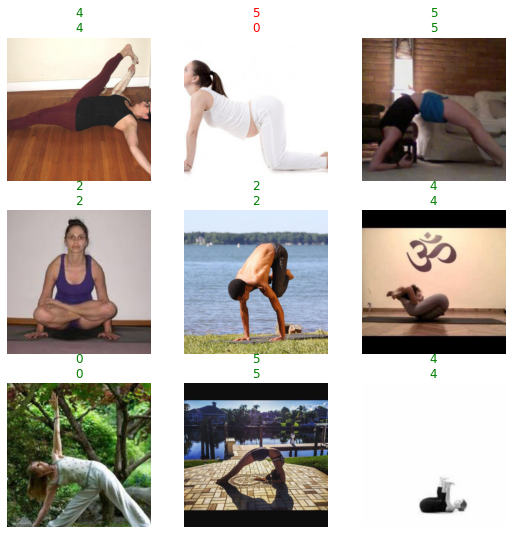

In [21]:
learn.loss_func = FocalLossFlat()
learn.show_results()

In [22]:
interp = Interpretation.from_learner(learn)

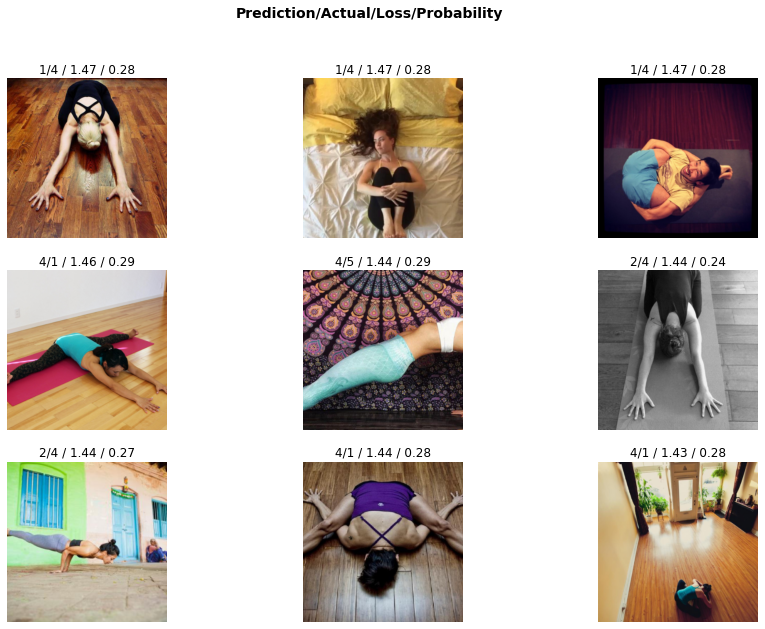

In [23]:
interp.plot_top_losses(9, figsize=(15,10))

# 5. Perform Inference
- Note, some configuration for how the submission should look is required per data set
- Also, need to have the DataLoader and model defined.

In [24]:
def ensemble_inference(test_dl, learn, model_files):
    avg_preds = []
    for i in range(len(model_files)):
        learn.load(model_files[i])
        preds, _ = learn.tta(dl = test_dl)
        avg_preds.append(preds.to('cpu').numpy())
        
    return np.mean(avg_preds, axis=0)

In [25]:
model_files = [os.path.join(CFG.model_path, CFG.model_dir, CFG.model_name+"_"+str(0)) for fold in range(CFG.num_folds)]

In [26]:
dls = get_data(train_df, 0)
test_dl = dls.test_dl(test_df)
learn = get_learner(dls).to_non_native_fp32()

In [ ]:
preds, _ = learn.get_preds(dl=test_dl)

In [27]:
preds = ensemble_inference(test_dl, learn, model_files)

/opt/conda/lib/python3.9/site-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Text(0.5, 1.0, 'Distirbution of Training Labels')

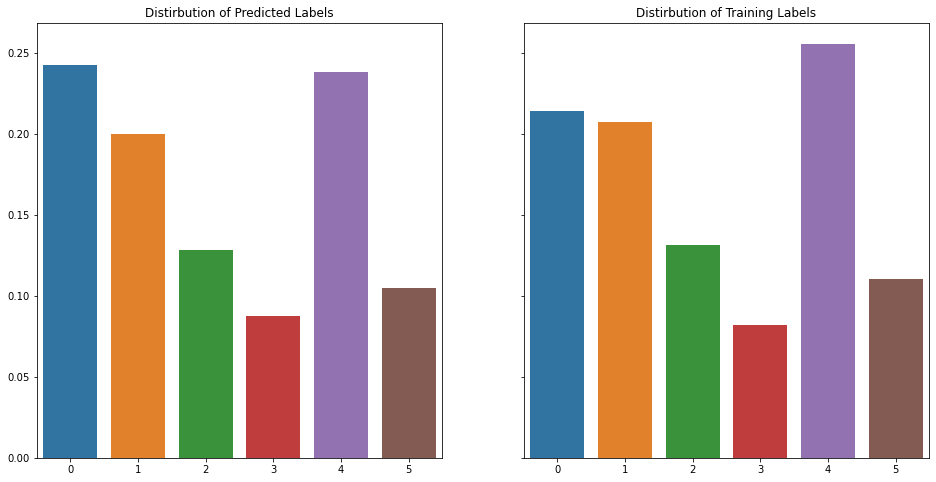

In [31]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,8))
x,counts = np.unique(preds.argmax(1), return_counts=True)
counts = counts/np.sum(counts)
sns.barplot(x=x, y=counts, ax=axs[0])
axs[0].set_title("Distirbution of Predicted Labels")
x,counts = np.unique(train_df[CFG.label_col], return_counts=True)
counts = counts/np.sum(counts)
sns.barplot(x=x, y=counts, ax=axs[1])
axs[1].set_title("Distirbution of Training Labels")

In [43]:
submission_df = test_df.copy()
submission_df['hobbies'] = preds.argmax(1)
submission_df = submission_df.replace({"hobbies": dict( enumerate(train_df['hobby'].astype("category").cat.categories ) ) })
submission_df = pd.DataFrame(submission_df['hobbies'])

In [30]:
submission_df.to_csv("fastai_ensemble_resnext_function_arc_loss_01.csv", index=False)

In [29]:
submission_df = test_df.copy()
submission_df = submission_df[['image_id','class_6']]
submission_df['class_6'] = preds.argmax(1)
submission_df

,image_id,class_6
0,18c514201d4d375596eaf057d43faa73.jpg,5
1,742cd45c52ee2d9a4745b27e1c5426a3.jpg,1
2,4ebf97acccead03c17d564c6701403ae.jpg,4
3,3a0fe12ec506d9fe99c0e370bce7eeef.jpg,3
4,d3442c050dd87db8b926b449408d793a.jpg,0
...,...,...
751,82689f579b379887337fbcc543d6e34e.jpg,1
752,3dd40670c0bb111d98f873679a31f0a3.jpg,4
753,3a57b3a17a5f0eed4f2a4b8a5fa8f81b.jpg,1
754,1ad75bfc569079f19e72fc44f47f76a6.jpg,4


In [30]:
submission_df.to_csv("fastai_ensemble_resnext_function_arc_loss_01.csv", index=False)